In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
df = pd.read_excel("./data/real_estate1.xlsx")
df.head()

,id,space,room,value
0,1,50,2LDK,3050
1,2,70,2LDK,4690
2,3,70,2SLDK,4830
3,4,70,3LDK,5040
4,5,90,3LDK,6570


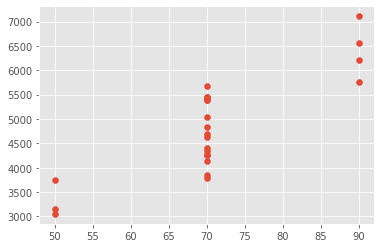

In [3]:
plt.scatter(df["space"], df["value"])

spaceが70のところは，ばらつきが大きいことが分かる  
駅からの距離などで価格が変わっているものと考えられる  
しかしここではとりあえずspaceだけ見て予測を行っていく

In [4]:
stan_model = """
data {
    int N;
    real X[N];
    real Y[N];
}

parameters {
    real a;
    real b;
    real<lower=0> sigma;
}

model {
    for (n in 1:N) {
        Y[n] ~ normal(a * X[n] + b, sigma);
    }
}
"""

In [5]:
sm = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4b38226c4e28fcc4abf674a669586099 NOW.


In [6]:
stan_data = {"N": df.shape[0], "X": df["space"], "Y": df["value"]}

In [7]:
fit = sm.sampling(data = stan_data, iter=2000, warmup=500, chains=3, seed=123)

In [8]:
fit

Inference for Stan model: anon_model_4b38226c4e28fcc4abf674a669586099.
3 chains, each with iter=2000; warmup=500; thin=1; 
post-warmup draws per chain=1500, total post-warmup draws=4500.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      79.03    0.34  11.64  55.52  71.61  78.88  86.74  102.2   1175    1.0
b     -764.1   24.21 834.46  -2433  -1315 -764.7 -230.8 907.49   1188    1.0
sigma 614.85    2.95 106.34  447.4 540.73 601.81 673.65 855.25   1303    1.0
lp__  -152.0    0.04   1.35 -155.3 -152.6 -151.6 -151.0 -150.5   1096    1.0

Samples were drawn using NUTS at Sat Aug 24 20:38:09 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

Rhat: 1に近いほど収束  
aのmeanは79ほどということで，1m2増えるごとに約80万増額することが分かる  
bのmeanは負の値だが，これは0m2の物件がないのでOK  
sigmaのmeanがかなり大きいのは先ほど見た

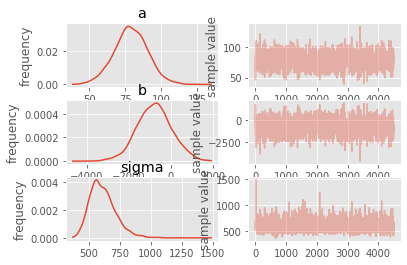

In [9]:
fig = fit.plot()

まんべんなくサンプリングしているので収束していることが分かる  
sigmaの分布が少し左に寄っているのは，ばらつきが大きいことがあることを示す

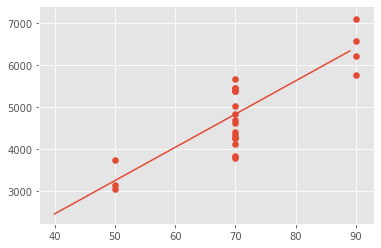

In [10]:
a = 79.3
b = -713.7
x = np.arange(40, 90, 1)
y = a * x + b
plt.plot(x, y)
plt.scatter(df["space"], df["value"])

出てきた値を使って，回帰直線を描くことができた  
次回は，
- ベイズ信頼区間：この回帰直線の信頼性を測る
- ベイズ予測区間：サンプリングによって観測値の幅の相場を測る

といったことを行う